# Prediction of true news

## Imports

In [59]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from joblib import dump, load
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC

from src.search_proc import SearchProc
from src.tfidf_preprocessor import (build_tfidf_preprocessor,
                                    get_features_names_out)

pd.set_option("display.max_columns", None);

## Read data

In [4]:
train = pd.read_csv("../data/train.csv", sep="\t")
test = pd.read_csv("../data/test.csv", sep="\t")
train.head()

title  is_fake
0  Москвичу Владимиру Клутину пришёл счёт за вмеш...        1
1  Агент Кокорина назвал езду по встречке житейск...        0
2  Госдума рассмотрит возможность введения секрет...        1
3  ФАС заблокировала поставку скоростных трамваев...        0
4  Против Навального завели дело о недоносительст...        1

## View data

In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5758 entries, 0 to 5757
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    5758 non-null   object
 1   is_fake  5758 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 90.1+ KB


In [6]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    1000 non-null   object
 1   is_fake  1000 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 15.8+ KB


In [7]:
train["is_fake"].value_counts()

is_fake
1    2879
0    2879
Name: count, dtype: int64

In [8]:
test["is_fake"].value_counts()

is_fake
0    1000
Name: count, dtype: int64

## Checking for possible additional feature in training

Признаки выбраны как простые текстовые метрики, отражающие стилистику заголовков, часто ассоциируемую с фейковыми новостями: длина, пунктуация, заглавные буквы, цифры и длина слов.

In [9]:
def extract_features(df):
    return pd.DataFrame(
        {
            "len": df["title"].str.len(),
            "num_punctuation": df["title"].str.count("[:,.!?]"),
            "num_upper": df["title"].str.count(r"[A-ZА-Я]"),
            "num_digits": df["title"].str.count(r"\d"),
            "mean_word_len": df["title"].apply(
                lambda x: np.mean([len(w) for w in x.split()])
            ),
            "is_fake": df["is_fake"],
        }
    )


add_features = extract_features(train)
add_features["has_digits"] = (add_features["num_digits"] > 0).astype(int)

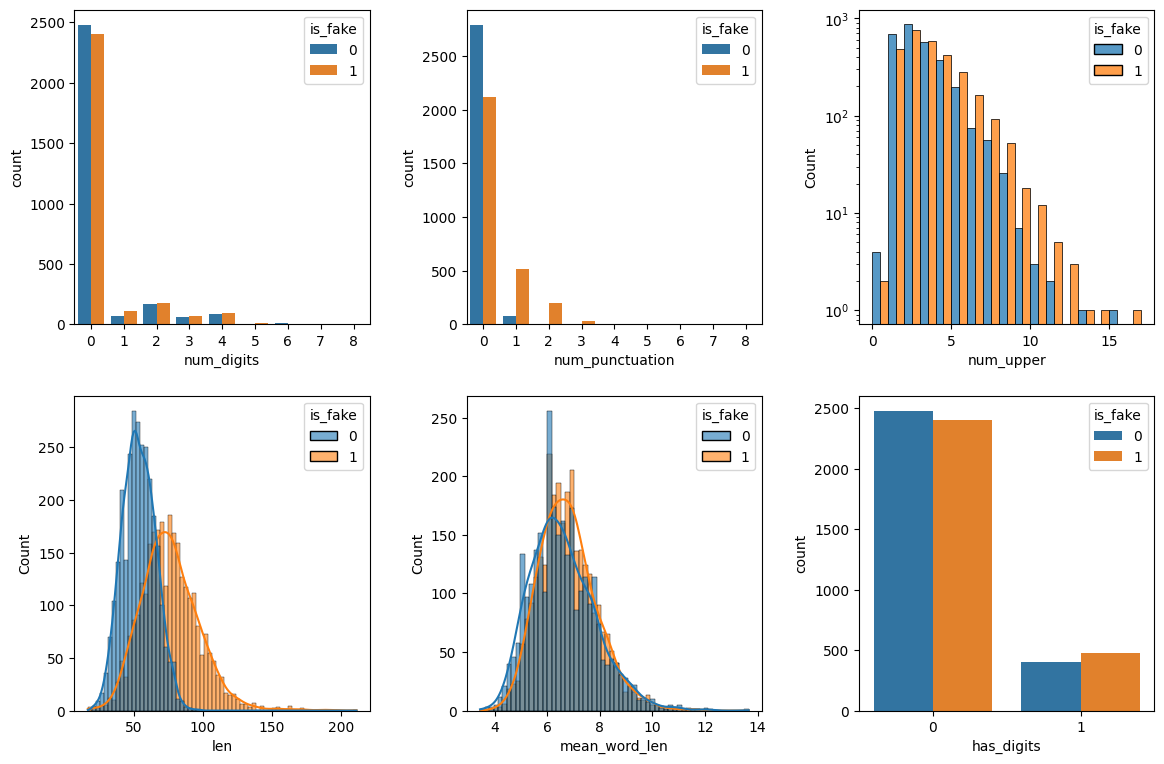

In [10]:
plt.figure(figsize=(12, 8))

plt.subplot(231)
sns.countplot(data=add_features, x="num_digits", hue="is_fake")

plt.subplot(232)
sns.countplot(add_features, x="num_punctuation", hue="is_fake")

plt.subplot(233)
plt.yscale("log")
sns.histplot(
    data=add_features, x="num_upper", hue="is_fake", multiple="dodge", binwidth=1
)

plt.subplot(234)
sns.histplot(add_features, x="len", hue="is_fake", alpha=0.6, kde=True)

plt.subplot(235)
sns.histplot(add_features, x="mean_word_len", hue="is_fake", alpha=0.6, kde=True)

plt.subplot(236)
sns.countplot(data=add_features, x="has_digits", hue="is_fake")

plt.tight_layout(pad=2.0);

**Из визуализации этих признаков я решил оставить в качестве дополнительных признаков только num_punctuation, num_upper и len.**


## Preprocessing

In [60]:
tfidf_preprocessor = build_tfidf_preprocessor()

In [61]:
y = train["is_fake"]
X = pd.DataFrame(train["title"], columns=["title"])
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, stratify=y)

## Baseline Model

In [79]:
pipe = Pipeline([("preprocessor", tfidf_preprocessor), ("model", LogisticRegression())])
pipe.set_params(
    preprocessor__features__featureextractor__features_names=["dummy_feature"]
)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('text',
                                                  Pipeline(steps=[('textpreprocessor',
                                                                   TextPreprocessor()),
                                                                  ('tfidfvectorizer',
                                                                   TfidfVectorizer())]),
                                                  'title'),
                                                 ('features',
                                                  Pipeline(steps=[('featureextractor',
                                                                   FeatureExtractor()),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  'title')])),
                ('model', LogisticRegression())])

In [66]:
pipe.fit(X_train, y_train);

In [85]:
data = tfidf_preprocessor.fit_transform(X_train)

In [67]:
y_pred = pipe.predict(X_val)

In [68]:
print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

           0       0.85      0.87      0.86       576
           1       0.87      0.85      0.86       576

    accuracy                           0.86      1152
   macro avg       0.86      0.86      0.86      1152
weighted avg       0.86      0.86      0.86      1152



## Search best model and params

### LogisticRegression

In [80]:
general = {
    "preprocessor__features__featureextractor__features_names": [
        ["dummy_feature"],
        ["len"],
        ["len", "num_punctuation"],
        ["len", "num_punctuation", "num_upper"],
    ]
}

param_grid_lr = {
    "model__solver": ["saga"],
    "model__penalty": ["l1", "l2"],
    "model__max_iter": [100000],
    "model__C": [0.001, 0.01, 0.1, 1, 10],
    "model__n_jobs": [-1],
    **general,
}

In [81]:
proc_lr = SearchProc(
    LogisticRegression,
    param_grid_lr,
    tfidf_preprocessor,
    n_iter=50,
    scoring="f1",
    verbose=10,
)

proc_lr.run_proc(X_train, X_val, y_train, y_val)

Starting hyperparameter search (40 params)...
Fitting 5 folds for each of 40 candidates, totalling 200 fits
[CV 1/5; 2/40] START model__C=0.001, model__max_iter=100000, model__n_jobs=-1, model__penalty=l1, model__solver=saga, preprocessor__features__featureextractor__features_names=['len']
[CV 5/5; 1/40] START model__C=0.001, model__max_iter=100000, model__n_jobs=-1, model__penalty=l1, model__solver=saga, preprocessor__features__featureextractor__features_names=['dummy_feature']
[CV 3/5; 1/40] START model__C=0.001, model__max_iter=100000, model__n_jobs=-1, model__penalty=l1, model__solver=saga, preprocessor__features__featureextractor__features_names=['dummy_feature']
[CV 1/5; 1/40] START model__C=0.001, model__max_iter=100000, model__n_jobs=-1, model__penalty=l1, model__solver=saga, preprocessor__features__featureextractor__features_names=['dummy_feature']
[CV 2/5; 1/40] START model__C=0.001, model__max_iter=100000, model__n_jobs=-1, model__penalty=l1, model__solver=saga, preprocessor

### SVC

In [90]:
param_grid_svc = [
    {
        **general,
        "model__kernel": ["linear"],
        "model__C": [0.1, 1, 10],
        "model__probability": [True],
    },
    {
        **general,
        "model__kernel": ["poly", "rbf", "sigmoid"],
        "model__C": [0.1, 1, 10],
        "model__gamma": ["scale", 0.01],
        "model__probability": [True],
    },
]

In [91]:
proc_svc = SearchProc(
    SVC, param_grid_svc, tfidf_preprocessor, n_iter=150, scoring="f1", verbose=10
)

proc_svc.run_proc(X_train, X_val, y_train, y_val)

Starting hyperparameter search (84 params)...
Fitting 5 folds for each of 84 candidates, totalling 420 fits
[CV 2/5; 1/84] START model__C=0.1, model__kernel=linear, model__probability=True, preprocessor__features__featureextractor__features_names=['dummy_feature']
[CV 1/5; 1/84] START model__C=0.1, model__kernel=linear, model__probability=True, preprocessor__features__featureextractor__features_names=['dummy_feature']
[CV 5/5; 1/84] START model__C=0.1, model__kernel=linear, model__probability=True, preprocessor__features__featureextractor__features_names=['dummy_feature']
[CV 3/5; 2/84] START model__C=0.1, model__kernel=linear, model__probability=True, preprocessor__features__featureextractor__features_names=['len']
[CV 3/5; 1/84] START model__C=0.1, model__kernel=linear, model__probability=True, preprocessor__features__featureextractor__features_names=['dummy_feature']
[CV 4/5; 1/84] START model__C=0.1, model__kernel=linear, model__probability=True, preprocessor__features__featureextr

### GradientBoostingClassifier

In [70]:
param_grid_gb = {
    "model__n_estimators": [50, 100, 150],
    "model__learning_rate": [0.05, 0.1, 0.2],
    "model__max_depth": [3, 5, 7],
    "model__min_samples_split": [2, 5],
    "model__max_features": ["sqrt", "log2"],
    **general,
}

In [74]:
proc_gb = SearchProc(
    GradientBoostingClassifier,
    param_grid_gb,
    tfidf_preprocessor,
    n_iter=100,
    scoring="f1",
    verbose=10,
)

proc_gb.run_proc(X_train, X_val, y_train, y_val)

Starting hyperparameter search (100 params)...
Fitting 5 folds for each of 100 candidates, totalling 500 fits
[CV 1/5; 1/100] START model__learning_rate=0.2, model__max_depth=5, model__max_features=log2, model__min_samples_split=5, model__n_estimators=150, preprocessor__features__featureextractor__features_names=['len']
[CV 2/5; 1/100] START model__learning_rate=0.2, model__max_depth=5, model__max_features=log2, model__min_samples_split=5, model__n_estimators=150, preprocessor__features__featureextractor__features_names=['len']
[CV 3/5; 1/100] START model__learning_rate=0.2, model__max_depth=5, model__max_features=log2, model__min_samples_split=5, model__n_estimators=150, preprocessor__features__featureextractor__features_names=['len']
[CV 5/5; 1/100] START model__learning_rate=0.2, model__max_depth=5, model__max_features=log2, model__min_samples_split=5, model__n_estimators=150, preprocessor__features__featureextractor__features_names=['len']
[CV 4/5; 1/100] START model__learning_rate

### RandomForestClassifier

In [77]:
param_grid_rf = {
    "model__n_estimators": [50, 100, 150, 200],
    "model__max_depth": [10, 20, 30, 40, 70],
    "model__max_features": ["sqrt", "log2"],
    "model__n_jobs": [-1],
    **general,
}

In [78]:
proc_rf = SearchProc(
    RandomForestClassifier, param_grid_rf, tfidf_preprocessor, n_iter=500, scoring="f1"
)

proc_rf.run_proc(X_train, X_val, y_train, y_val)

Starting hyperparameter search (160 params)...
Hyperparameter search completed in 473.32 seconds

Training best model...
Best model trained in 2.68 seconds

              precision    recall  f1-score   support

           0       0.80      0.94      0.87       576
           1       0.93      0.77      0.84       576

    accuracy                           0.85      1152
   macro avg       0.86      0.85      0.85      1152
weighted avg       0.86      0.85      0.85      1152
 

Top 3 combinations:
+-----------------+---------------------------------------------------------------------------------------------------+-------------------+
|  mean_fit_time  | params                                                                                            |  mean_test_score  |
+=================+===================================================================================================+===================+
|      3.88       | preprocessor__features__featureextractor__features_nam

### Search results for the best parameters and models

In [92]:
print("Best f1 score: ")
print(f"lr: {round(float(proc_lr.search_model.best_score_), 4)}")
print(f"svc: {round(float(proc_svc.search_model.best_score_), 4)}")
print(f"rf: {round(float(proc_rf.search_model.best_score_), 4)}")
print(f"gb: {round(float(proc_gb.search_model.best_score_), 4)}")

Best f1 score: 
lr: 0.875
svc: 0.8737
rf: 0.8288
gb: 0.8314


In [93]:
def print_hyperparameter(params, label):
    print(label)
    for k, v in params.items():
        print(f"hyperparameter {k} = {v}")
    print()


print("Best Hyperparameters: \n")
print_hyperparameter(proc_lr.search_model.best_params_, "lr:")
print_hyperparameter(proc_svc.search_model.best_params_, "svc:")
print_hyperparameter(proc_rf.search_model.best_params_, "rf:")
print_hyperparameter(proc_gb.search_model.best_params_, "gb:")

Best Hyperparameters: 

lr:
hyperparameter preprocessor__features__featureextractor__features_names = ['len', 'num_punctuation', 'num_upper']
hyperparameter model__solver = saga
hyperparameter model__penalty = l2
hyperparameter model__n_jobs = -1
hyperparameter model__max_iter = 100000
hyperparameter model__C = 10

svc:
hyperparameter preprocessor__features__featureextractor__features_names = ['len', 'num_punctuation', 'num_upper']
hyperparameter model__probability = True
hyperparameter model__kernel = linear
hyperparameter model__C = 1

rf:
hyperparameter preprocessor__features__featureextractor__features_names = ['len', 'num_punctuation']
hyperparameter model__n_jobs = -1
hyperparameter model__n_estimators = 150
hyperparameter model__max_features = log2
hyperparameter model__max_depth = 70

gb:
hyperparameter preprocessor__features__featureextractor__features_names = ['len', 'num_punctuation', 'num_upper']
hyperparameter model__n_estimators = 150
hyperparameter model__min_samples_spl

1. **Лучший результат в CV у модели LogReg accuracy = 0.875**
2. **Во всех моделях дополнительные признаки добавили точности**
3. **Получили прирост точности по сравнению с baseline моделью на тестовых данных accuracy: 0.86->0.88**

In [94]:
lr_pipeline = proc_lr.model
svc_pipeline = proc_svc.model
gb_pipeline = proc_gb.model
rf_pipeline = proc_rf.model

dump(lr_pipeline, "../models/lr_pipeline.joblib")
dump(svc_pipeline, "../models/svc_pipeline.joblib")
dump(gb_pipeline, "../models/gb_pipeline.joblib")
dump(rf_pipeline, "../models/rf_pipeline.joblib");

## Filling test csv

In [97]:
pipe = load("../models/lr_pipeline.joblib")

In [98]:
pipe.fit(X_train, y_train);

In [99]:
X = pd.DataFrame(test["title"], columns=["title"])

y_pred = pipe.predict(X)
probs = pipe.predict_proba(X)

In [100]:
test_result = pd.DataFrame(
    {"title": X.iloc[:, 0], "is_fake": y_pred, "prob_fake": probs[:, 1]}
)

In [103]:
test_result.to_csv("../data/tfidf_predictions.csv", sep="\t", index=False)